In [549]:
import os
import torch
import torch.nn as nn 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0" # GPU index

print("Available GPUs:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print(device)

Available GPUs: 1
GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU
cuda:0


In [550]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [551]:
import torch 
import sys
sys.path.insert(1, os.path.join("..", "data"))
sys.path.insert(1, os.path.join("..", "utils"))
from data_utils import Dataset
from plot_utils import plot_image
from torch.utils.data import DataLoader

In [552]:
# Path to the data folder (update the variable to your path).
path_data=os.path.join("..", "data")
# Seed value
seed=709

In [553]:
dataset=Dataset(path_data=path_data, seed=seed)
dataset.read_data()
dataset.get_statistics()

Parsing class: Cloud: 146it [00:08, 17.32it/s]
Parsing class: Edge: 97it [00:04, 22.64it/s]
Parsing class: Good: 61it [00:03, 19.53it/s]


train  valid  test
cloud     98     28    20
edge      70     12    15
good      44      6    11

In [554]:
batch_size=32
# Train loader
train_loader = DataLoader(dataset.get_split("train"), batch_size=batch_size, pin_memory=False, shuffle=True)
# Cross validation data loader
valid_loader = DataLoader(dataset.get_split("valid"), batch_size=batch_size, pin_memory=False, shuffle=True)
# Test data loader
test_loader = DataLoader(dataset.get_split("test"), batch_size=batch_size, pin_memory=False, shuffle=True)

In [555]:

classes = ('cloud', 'edge', 'good')

Start of training loop

In [556]:
import torch.nn.functional as F 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# def resize_tensor_images(images, size=(256, 128)):
#     # Resize the batch of images
#     return F.interpolate(images, size=size, mode='bilinear', align_corners=False)

def compute_mean_std(loader):
    # Computation of mean and standard deviation of batches


    num_of_pixels_per_channel = 212 * 256 * 128  # This remains the same since we're doing it per channel

    total_sum_channels = torch.tensor([0.0, 0.0, 0.0])  # One for each channel
    for batch in loader:
        # Assuming batch[0] contains image data in the shape [batch, channels, height, width]
        total_sum_channels += batch[0].view(batch[0].size(0), batch[0].size(1), -1).sum(dim=[0, 2])

    mean = total_sum_channels / num_of_pixels_per_channel

    sum_of_squared_error_channels = torch.tensor([0.0, 0.0, 0.0])
    for batch in loader:
        # We subtract the mean for each channel and then square it
        sum_of_squared_error_channels += ((batch[0] - mean.view(1, -1, 1, 1)) ** 2).view(batch[0].size(0), batch[0].size(1), -1).sum(dim=[0, 2])

    std = torch.sqrt(sum_of_squared_error_channels / num_of_pixels_per_channel)

    return mean, std

def normalize_images(images, mean, std):
    # Normalizing images with previously computed mean and standard deviation
    normalized_images = (images - mean.view(-1, 1, 1)) / std.view(-1, 1, 1)
    return normalized_images
    
def tensor_to_numpy(tensor):
    # Rescale the tensor to 0-1 range
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    # Move the tensor to CPU if it's on GPU
    tensor = tensor.cpu()
    # Convert to numpy and transpose from CxHxW to HxWxC for visualization
    numpy_image = tensor.numpy()
    numpy_image = np.transpose(numpy_image, (1, 2, 0))

    return numpy_image

In [557]:
mean, std = compute_mean_std(train_loader)

In [558]:
def normalization(data_loader, mean, std):
    UNPRO_batches = []
    batches = []
    
    for batch in data_loader:
        images, labels = batch
        # resized_images = resize_tensor_images(images)
        UNPRO_batches.append((images, labels))
        normalized_alldata_images = normalize_images(images, mean, std)

        # Append the normalized images and their corresponding labels to the list
        batches.append((normalized_alldata_images, labels))
    return UNPRO_batches, batches

UNPRO_batches_TRL, batches_TRL = normalization(train_loader, mean, std)
UNPRO_batches_VAL, batches_VAL = normalization(valid_loader, mean, std)
UNPRO_batches_TST, batches_TST = normalization(test_loader, mean, std)


In [559]:
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(seed=42)
torch.cuda.manual_seed(seed=42)

# Definition of the neural network class
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Definition of the first convolutional layer with batch normalization, rectified linear unit function and maxpooling.
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # Definition of the second convolutional layer with batch normalization, rectified linear unit function, maxpooling and average pooling.
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AvgPool2d(3, 3),
        )
        # Definition of the fully connected classifier layer with rectified linear unit function.
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=5120,
                      out_features=132),
            nn.ReLU(),
            nn.Linear(in_features=132,
                      out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,
                      out_features=3),
        )

    # Changing forward function of the nn.Module class to the defined layers.
    def forward(self, x):

        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.classifier(x)

        return x
# Making an instance of the neural network and setting it to the gpu    
net = Net().to(device)

In [560]:
import torch.optim as optim

# Calculating the count of cloud, edge and good images in the training dataset
cloud_count = 0
edge_count = 0
good_count = 0
for image, label in dataset.get_split("train"):
    if label == 0: 
        cloud_count += 1
    if label == 1: 
        edge_count += 1
    if label == 2: 
        good_count += 1

# Setting the loss with weights calculated by the cound of cloud, edge and good images and setting it to the gpu.
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1, cloud_count/edge_count, cloud_count/good_count]).to(device))
# Setting the optimizer (Stochastic gradient decent) with a learning rate and a momentum
optimizer = optim.SGD(net.parameters(), lr=0.00003, momentum=0.9)

In [561]:
from torchmetrics import Accuracy
# Defining the accuracy function used to calculate accuracies in each step
accuracy_fn = Accuracy(task="multiclass", num_classes=3).to(device)

In [562]:
# Defining the train step function to be used in the training loop
def train_step(model: torch.nn.Module,
               batches,
               loss_fn,
               optimizer,
               accuracy,
               device: torch.device = device):
    # Setting the model to training mode
    model.train()
    train_loss, train_accuracy = 0, 0
    total_correct, total_examples = 0, 0
    # Looping over the multiple batches of the training dataset 
    for batch, (images, labels) in enumerate(batches, 0):
        
        # Setting the image data to the gpu
        images, labels = images.to(device), labels.to(device)
        batch_size = images.size(0)
        # Putting the images through the model
        y_logits = model(images)

        # Calculate loss on 1 batch of data
        loss = loss_fn(y_logits, labels)
        # Calculating the accuracy on 1 batch of data
        train_loss += loss.item() * batch_size

        total_correct += accuracy(y_logits.argmax(dim=-1), labels).item() * batch_size
        total_examples += batch_size
        # Setting optimizer gradients to 0
        optimizer.zero_grad()
        # Calculating gradients of the weights in the neural network on the loss
        loss.backward()
        # Stepping in the negative gradient direction to optimize the weights
        optimizer.step()
    # Calculating accuracy of the whole dataset
    # Calculating loss of the whole dataset
    train_loss /= total_examples
    train_accuracy = total_correct / total_examples

    # Printing loss and accuracy
    print(f"Train Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy*100:.4f}")
    return train_accuracy, train_loss

In [563]:
def validation_step(model,
              batches,
              loss_fn,
              accuracy,
              device: torch.device = device):
    validation_loss, validation_accuracy = 0, 0
    total_correct, total_examples = 0, 0
    # Setting the model to evaluation mode
    model.eval()
    # Setting the model to inference mode (gradients aren't computed)
    with torch.inference_mode():
        # Looping over batches
        for images_validation, labels_validation in batches:
            
            # Setting image data to the gpu
            images_validation, labels_validation = images_validation.to(device), labels_validation.to(device)
            batch_size = images_validation.size(0)
            # Running the images through the model
            validation_logits = model(images_validation)
            # Calculating loss and accuracy for one batch
            validation_loss += loss_fn(validation_logits, labels_validation).item() * batch_size

            total_correct += accuracy(validation_logits.argmax(dim=-1), labels_validation).item() * batch_size
            total_examples += batch_size
        # Calculating loss and accuracy for all batches
        validation_loss /= total_examples
        validation_accuracy = total_correct / total_examples
    # Printing loss and accuracy
    print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy*100:.4f}%")
    return validation_accuracy, validation_loss

In [564]:
def test_step(model,
              batches,
              loss_fn,
              accuracy,
              device: torch.device = device):
    test_loss, test_accuracy = 0, 0
    total_correct, total_examples = 0, 0
    # Setting the model to evaluation mode
    model.eval()
    # Setting the model to inference mode (gradients aren't computed)
    with torch.inference_mode():
        # Looping over batches
        for images_test, labels_test in batches:
            
            # Setting image data to the gpu
            images_test, labels_test = images_test.to(device), labels_test.to(device)
            batch_size = images_test.size(0)
            # Running the images through the model
            test_logits = model(images_test)
            # Calculating loss and accuracy for one batch
            test_loss += loss_fn(test_logits, labels_test).item() * batch_size

            total_correct += accuracy(test_logits.argmax(dim=-1), labels_test).item() * batch_size
            total_examples += batch_size
        # Calculating loss and accuracy for all batches
        test_loss /= total_examples
        test_accuracy = total_correct / total_examples
        print(total_correct)
    # Printing loss and accuracy
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.4f}%")
    return test_accuracy, test_loss

In [565]:
from tqdm.auto import tqdm
# Number of loops the model will train for
epochs = 650
# Creating lists for loss and accuracy data
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []
net.to(device)
# Performing training
for epoch in tqdm(range(epochs)):
    train_accuracy, train_loss = train_step(model=net,
               batches=batches_TRL,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy=accuracy_fn,
               device=device
               )
    val_accuracy, val_loss = validation_step(model=net,
              batches=batches_VAL,
              loss_fn=loss_fn,
              accuracy=accuracy_fn,
              device=device)
    test_accuracy, test_loss = test_step(model=net,
              batches=batches_TST,
              loss_fn=loss_fn,
              accuracy=accuracy_fn,
              device=device)
    # Adding losses and accuracies to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

  0%|          | 0/650 [00:00<?, ?it/s]

Train Loss: 1.1034, Training Accuracy: 33.4906
Validation Loss: 1.1005, Validation Accuracy: 26.0870%
15.000000029802322
Test Loss: 1.1004, Test Accuracy: 32.6087%
Train Loss: 1.1018, Training Accuracy: 33.4906
Validation Loss: 1.1017, Validation Accuracy: 26.0870%
15.000000029802322
Test Loss: 1.1009, Test Accuracy: 32.6087%
Train Loss: 1.0993, Training Accuracy: 33.4906
Validation Loss: 1.1008, Validation Accuracy: 26.0870%
15.000000029802322
Test Loss: 1.1002, Test Accuracy: 32.6087%
Train Loss: 1.0965, Training Accuracy: 33.4906
Validation Loss: 1.0988, Validation Accuracy: 26.0870%
15.000000029802322
Test Loss: 1.0977, Test Accuracy: 32.6087%
Train Loss: 1.0935, Training Accuracy: 33.9623
Validation Loss: 1.0964, Validation Accuracy: 26.0870%
15.000000029802322
Test Loss: 1.0950, Test Accuracy: 32.6087%
Train Loss: 1.0906, Training Accuracy: 34.9057
Validation Loss: 1.0940, Validation Accuracy: 26.0870%
15.000000029802322
Test Loss: 1.0930, Test Accuracy: 32.6087%
Train Loss: 1.08

### Saving the model to a .pth file.

The usage for this is that we at least explain how many seeds were used, what the batch size was, as well as the seed.

In [566]:
# Saving the model
txt = './e{}_b{}_s{}.pth'.format(epochs, batch_size, seed)
PATH = txt
torch.save(net.state_dict(), PATH)
# Loading the model (not necessary but performed as test)
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### Function for concatenating batches

These make sure that we are not just using a batch for confusion matrices and plotting, but the whole split.

In [567]:
def concatenate_batches(batches):
    images_norm = torch.tensor([])
    # For loop over the batches
    for i, batch in enumerate(batches):
        images_batch, labels_batch = batch
        if i == 0:
            images_norm = images_batch
            labels_norm = labels_batch
        else:
            images_norm = torch.cat((images_norm, images_batch))
            labels_norm = torch.cat((labels_norm, labels_batch))
    return images_norm, labels_norm

# Concatenate all the batches of the different types of splits.
images_norm_TRL, labels_norm_TRL = concatenate_batches(batches_TRL)
images_norm_VAL, labels_norm_VAL = concatenate_batches(batches_VAL)
images_norm_TST, labels_norm_TST = concatenate_batches(batches_TST)

images_og_TST, labels_og_TST = concatenate_batches(UNPRO_batches_TST)

In [568]:
# Setting the model to the cpu
net.to('cpu')
# Running test data through model
outputs_TST = net(images_norm_TST.to('cpu'))

In [569]:
# Getting the predicted classes of the model
_, predicted_TST = torch.max(outputs_TST, 1)

predictions_TST = [classes[predicted_TST[j]] for j in range(len(predicted_TST))]

### Confusion matrix 
The confusion matrix of the test split is plotted using seaborn

C:\Users\ianma\AppData\Local\Temp\ipykernel_20800\3053328046.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(labels_og_TST)


<Axes: >

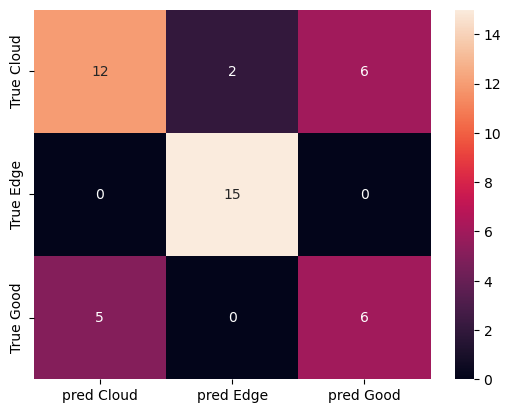

In [570]:
from torcheval.metrics import MulticlassConfusionMatrix
import seaborn as sn
import pandas as pd
class_mapping = {'cloud': 0, 'edge':1, 'good':2}

# Set x and y axis to corresponding predictions and true labels
input = predictions_TST
input = torch.tensor([class_mapping[class_name] for class_name in input])
target = torch.tensor(labels_og_TST)

# make the confusion matrix
metric = MulticlassConfusionMatrix(3)
metric.update(input=input, target=target)
confmat = metric.compute()
total_sum = np.sum(confmat.numpy())

# Group bad parts of the confusion matrix together for later use in true/false positives/negatives.
TN_confmat = np.array([[np.sum(confmat.numpy()[:2, :2]) / total_sum, np.sum(confmat.numpy()[:2, 2]) / total_sum], 
                               [np.sum(confmat.numpy()[2, :2]) / total_sum, np.sum(confmat.numpy()[2, 2]) / total_sum]])

# Convert the confusion matrix to a form for presentation with seaborn.
confmat = pd.DataFrame(confmat)
confmat.rename(index={0: 'True Cloud', 1: 'True Edge', 2: 'True Good'}, inplace=True)
confmat.rename(columns={0: 'pred Cloud', 1: 'pred Edge', 2: 'pred Good'}, inplace=True)


sn.heatmap(confmat, annot=True)

### Plotting each image, its normalized version, the true label, and the prediction from the model next to eachother for all images.

In this case, blue predictions correspond to correct predictions while yellow correspond to wrong predictions.

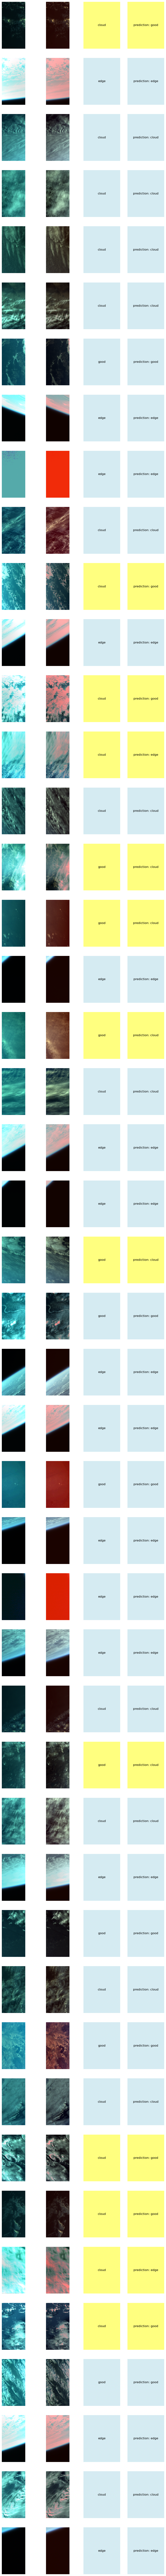

In [571]:
fig, axs = plt.subplots(46, 4, figsize=(12, 4 * 46))

# For loop to showcase all four pieces of information for all images.
for i in range(len(images_norm_TST)):
    og_img = tensor_to_numpy(images_og_TST[i])
    norm_img = tensor_to_numpy(images_norm_TST[i])
    
    axs[i, 0].imshow(og_img)
    axs[i, 0].axis('off')

    # Plot the second image
    axs[i, 1].imshow(norm_img)  # Assuming there are always pairs of images
    axs[i, 1].axis('off')

    # Plot the first text box
    axs[i, 2].text(0.5, 0.5, classes[labels_norm_TST[i]], ha='center', va='center', fontsize=12, color='black')
    axs[i, 2].axis('off')

    # Plot the second text box
    axs[i, 3].text(0.5, 0.5, 'prediction: ' + str(predictions_TST[i]), ha='center', va='center', fontsize=12, color='black')
    axs[i, 3].axis('off')
    if predictions_TST[i] == classes[labels_norm_TST[i]]:
        row_color = 'lightblue'  # Set to blue if the condition is true
    else:
        row_color = 'yellow'  # Set to yellow if the condition is false

    rect = patches.Rectangle((0, 0), 1, 1, linewidth=0, edgecolor='none', facecolor=row_color, alpha=0.5)
    axs[i, 0].add_patch(rect)
    axs[i, 1].add_patch(patches.Rectangle((0, 0), 1, 1, linewidth=0, edgecolor='none', facecolor=row_color, alpha=0.5))
    axs[i, 2].add_patch(patches.Rectangle((0, 0), 1, 1, linewidth=0, edgecolor='none', facecolor=row_color, alpha=0.5))
    axs[i, 3].add_patch(patches.Rectangle((0, 0), 1, 1, linewidth=0, edgecolor='none', facecolor=row_color, alpha=0.5))


### Plotting the training and cross-validation loss

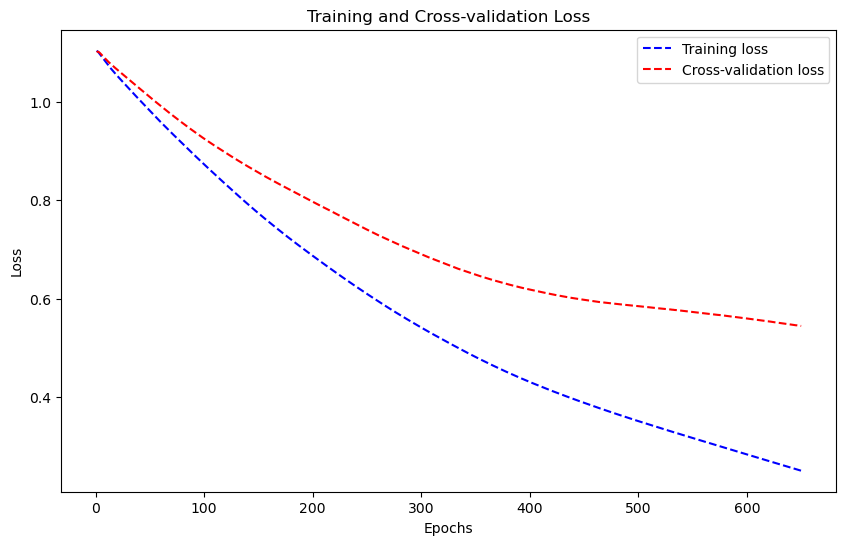

In [576]:


epochs = range(1, len(train_losses) + 1)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, 'b--', label='Training loss')
plt.plot(epochs, val_losses, 'r--', label='Cross-validation loss')
plt.title('Training and Cross-validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

### Printing false negatives in the code
Here the percentage of false negatives is printed.

In [573]:
false_negatives = 0
total_labels_TST = 0

# For loop over all predictions true test cases.
for i in range(len(predictions_TST)):
    if predictions_TST[i] != 'good' and labels_og_TST[i] == 2:
        false_negatives += 1
    if labels_og_TST[i] == 2:
        total_labels_TST += 1

percentage_false_negatives = 100 * false_negatives / total_labels_TST
print("The percentage of false negatives is : ", percentage_false_negatives, "%")


The percentage of false negatives is :  45.45454545454545 %


### Saving results to an excel file
We put the seed, accuracies, losses, and true/false positives/negatives into an excel such that averaging can be performed

In [574]:
import pandas as pd

# Define what you want to put into the excel.
data_current_run = {'Seed' : seed, 'Test accuracy': test_accuracies[-1], 'Validation accuracy': val_accuracies[-1], 'Train Accuracy': train_accuracies[-1], 'Validation loss': val_losses[-1],  'Train loss': train_losses[-1], 'True Negative': TN_confmat[0, 0], 'False Negative': TN_confmat[1, 0], 'False Positive': TN_confmat[0, 1], "True Positive" : TN_confmat[1, 1]}

# Read the Excel file
excel_file = 'seed_averaging.xlsx'
df = pd.read_excel(excel_file)

# Write to first available row
first_available_row = len(df)

# Append your data to the DataFrame
df = pd.concat([df, pd.DataFrame([data_current_run])], ignore_index=True)

# Save the DataFrame back to Excel
df.to_excel(excel_file, index=False)

PermissionError: [Errno 13] Permission denied: 'seed_averaging.xlsx'